# Project Phase 4: Data Mining
Group 3:
- Jason Lam
- Angus Young
- Ann Soong

In [1]:
import pandas as pd
import numpy as np

# For displaying graphs
import matplotlib.pyplot as plt

# For data preprocessing
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.feature_selection import VarianceThreshold # https://scikit-learn.org/stable/modules/feature_selection.html
from sklearn.impute import KNNImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# For data splitting
from sklearn.model_selection import train_test_split

# For model building: Decision Tree, Gradient Boosting and Random Forest
# From:
#   https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html
#       https://scikit-learn.org/stable/modules/generated/sklearn.tree.export_text.html
#       https://scikit-learn.org/stable/modules/generated/sklearn.tree.plot_tree.html
#   https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html
#   https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier

# For model analysis
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score
import time

np.random.seed(42)

## Part A
Since our database is a local database, we decided to use the .csv files instead, in order to remove the limitations of requiring a local database.

In [2]:
# Get the data from .csv files
df_fact_table = pd.read_csv('clean_data/fact_table.csv')
df_country = pd.read_csv('clean_data/country.csv')
df_education = pd.read_csv('clean_data/education.csv')
df_event = pd.read_csv('clean_data/event.csv')
df_health = pd.read_csv('clean_data/health.csv')
df_month = pd.read_csv('clean_data/month.csv')
df_population = pd.read_csv('clean_data/population.csv')
df_qualityOfLife = pd.read_csv('clean_data/quality_of_life.csv')

# Country and Event both have 'Name' columns. Rename to be specific.
df_country = df_country.rename(
    columns={
        'Name': 'country_name'
    }
)
df_event = df_event.rename(
    columns={
        'Name': 'event_name'
    }
)

# Join all the data into one dataframe
df_tmp = pd.merge(df_fact_table, df_country,  how='left', left_on=['country_key'], right_on = ['Country_key'])
df_tmp = pd.merge(df_tmp, df_month,  how='left', left_on=['month_key'], right_on = ['Month_Key'])
df_tmp = pd.merge(df_tmp, df_education,  how='left', left_on=['education_key'], right_on = ['education_key'])
df_tmp = pd.merge(df_tmp, df_event,  how='left', left_on=['Event_key'], right_on = ['Event_key'])
df_tmp = pd.merge(df_tmp, df_health,  how='left', left_on=['health_key'], right_on = ['health_key'])
df_tmp = pd.merge(df_tmp, df_population,  how='left', left_on=['population_key'], right_on = ['population_key'])
df_tmp = pd.merge(df_tmp, df_qualityOfLife,  how='left', left_on=['qol_key'], right_on = ['qol_key'])
# Drop keys
df_dataset = df_tmp.drop(columns=['country_key', 'Country_key', 'month_key', 'Month_Key', 'education_key', 'Event_key', 'health_key', 'population_key', 'qol_key'])

df_dataset.head(2446)

,qol,di,hdi,country_name,Region,Continent,Currency,Capital,Total_population,Population_growth_percent,...,unemployment_total,people_basic_handwashing_facilities,people_basic_handwashing_facilities_rural,people_basic_handwashing_facilities_urban,people_using_at_least_basic_sanitation_services,people_using_at_least_basic_sanitation_services_rural,people_using_at_least_basic_sanitation_services_urban,people_using_at_least_basic_drinking_water_services,people_using_at_least_basic_drinking_water_services_rural,people_using_at_least_basic_drinking_water_services_urban
0,4.0,2.0,4.0,Bangladesh,South Asia,Asia,Bangladeshi taka,Dhaka,139035505.0,1.484747,...,4.119,31.433841,23.044502,49.266924,42.114532,39.003389,48.727843,96.691589,96.110444,97.926927
1,4.0,2.0,4.0,Bangladesh,South Asia,Asia,Bangladeshi taka,Dhaka,139035505.0,1.484747,...,4.119,31.433841,23.044502,49.266924,42.114532,39.003389,48.727843,96.691589,96.110444,97.926927
2,4.0,2.0,4.0,Bangladesh,South Asia,Asia,Bangladeshi taka,Dhaka,139035505.0,1.484747,...,4.119,31.433841,23.044502,49.266924,42.114532,39.003389,48.727843,96.691589,96.110444,97.926927
3,4.0,2.0,4.0,Bangladesh,South Asia,Asia,Bangladeshi taka,Dhaka,139035505.0,1.484747,...,4.119,31.433841,23.044502,49.266924,42.114532,39.003389,48.727843,96.691589,96.110444,97.926927
4,4.0,2.0,4.0,Bangladesh,South Asia,Asia,Bangladeshi taka,Dhaka,139035505.0,1.484747,...,4.119,31.433841,23.044502,49.266924,42.114532,39.003389,48.727843,96.691589,96.110444,97.926927
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2441,1.0,1.0,2.0,United States,North America,North America,U.S. dollar,"Washington, D.C.",329484123.0,0.350911,...,4.620,100.000000,100.000000,100.000000,99.881540,99.996330,99.853020,98.860837,95.511316,99.693042
2442,1.0,1.0,2.0,United States,North America,North America,U.S. dollar,"Washington, D.C.",329484123.0,0.350911,...,4.620,100.000000,100.000000,100.000000,99.881540,99.996330,99.853020,98.860837,95.511316,99.693042
2443,1.0,1.0,2.0,United States,North America,North America,U.S. dollar,"Washington, D.C.",329484123.0,0.350911,...,4.620,100.000000,100.000000,100.000000,99.881540,99.996330,99.853020,98.860837,95.511316,99.693042
2444,1.0,1.0,2.0,United States,North America,North America,U.S. dollar,"Washington, D.C.",329484123.0,0.350911,...,4.620,100.000000,100.000000,100.000000,99.881540,99.996330,99.853020,98.860837,95.511316,99.693042


### Data summarization

In [3]:
# Data summarization part goes here!

### Data transformation

In [4]:
# Dropping attributes that we feel are not relevant or redundant to our data mining
df_processing = df_dataset.drop(columns=[
    'country_name', 'Region', 'Continent', 'Currency', 'Capital', 'Income_group',
    'Month', 'Year', 'Quarter', 'Decade',
    'event_name', 'Disaster_group', 'Disaster_subgroup', 'Start_date','End_date', 'Start_month', 'End_month'
])

# Remove attributes that have insufficient data
df_processing = df_processing.drop(columns=[
    'primary_completion_rate_percent_m', 'primary_completion_rate_percent', 'primary_enroll_rate_percent_net_f', 'primary_enroll_rate_percent_net_m', 'spending_education_percent_gdp',
    'people_using_safely_managed_drinking_water_services', 'community_health_workers', 'specialist_surgical_workforce',
    'incidence_of_malaria', 'intermittent_preventive_treatment_of_malaria_in_pregnancy','use_of_insecticide_treated_bed_nets', 'children_with_fever_receiving_antimalarial_drugs', 'malaria_cases_reported',
    'people_using_safely_managed_sanitation_services', 'external_health_expenditure_per_capita'
])

# Fill categorical Null event data with 'Not Specified'
df_processing = df_processing.fillna(value={'Disaster_type':'Not Specified'})

# Separate the features and the labels to be used in model development
df_data = df_processing.drop(columns=['qol', 'di', 'hdi'])
df_labels = df_processing['hdi'].to_numpy(copy=True)

# Split the data into training and testing
train_data, test_data, train_labels, test_labels = train_test_split(df_data, df_labels, test_size=0.3, random_state=42) 

# State numerical columns and categorical columns
categorical_columns = ['Disaster_type']
numerical_columns = df_data.drop(columns=categorical_columns).columns

# Use pipelines to transform our data
numerical_pipeline = Pipeline([
    ('imputer', KNNImputer(n_neighbors=5)), # For imputing missing values
    ('std_scaler', StandardScaler()), # To scale the values so all attributes have more equal weight
])

full_pipeline = ColumnTransformer([
    ("num", numerical_pipeline, numerical_columns), # Numerical values set to the numerical pipeline
    ("cat", OneHotEncoder(), categorical_columns), # Categorical values get encoded
])

# Remove numerical columns where values are 20% the same
selector = VarianceThreshold(threshold=(0.8))
df_numerical = df_data.drop(columns=categorical_columns)
selector.fit(df_numerical)
low_var_col = [
    column for column in df_numerical.columns
        if column not in df_numerical.columns[selector.get_support()]
]

for features in low_var_col:
    print('COLUMN TO BE DROPPED: ' + features)

train_data.drop(low_var_col,axis=1)
test_data.drop(low_var_col,axis=1)

# Transform the data via the Pipelines
train_data = full_pipeline.fit_transform(train_data)
test_data = full_pipeline.fit_transform(test_data)

COLUMN TO BE DROPPED: Population_growth_percent
COLUMN TO BE DROPPED: population_growth


## Part B

### Decision Tree Model

:: 0.013999223709106445 seconds ::


C:\Users\angus\miniconda3\envs\csi4142\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[Text(0.5, 0.875, 'X[34] <= -0.3\nentropy = 2.124\nsamples = 1712\nvalue = [130, 304, 691, 317, 270]'),
 Text(0.25, 0.625, 'X[8] <= 0.755\nentropy = 1.302\nsamples = 1125\nvalue = [130, 304, 691, 0, 0]'),
 Text(0.125, 0.375, 'entropy = 0.0\nsamples = 691\nvalue = [0, 0, 691, 0, 0]'),
 Text(0.375, 0.375, 'X[49] <= 1.102\nentropy = 0.881\nsamples = 434\nvalue = [130, 304, 0, 0, 0]'),
 Text(0.25, 0.125, 'entropy = 0.0\nsamples = 304\nvalue = [0, 304, 0, 0, 0]'),
 Text(0.5, 0.125, 'entropy = 0.0\nsamples = 130\nvalue = [130, 0, 0, 0, 0]'),
 Text(0.75, 0.625, 'X[8] <= -1.347\nentropy = 0.995\nsamples = 587\nvalue = [0, 0, 0, 317, 270]'),
 Text(0.625, 0.375, 'entropy = 0.0\nsamples = 270\nvalue = [0, 0, 0, 0, 270]'),
 Text(0.875, 0.375, 'entropy = 0.0\nsamples = 317\nvalue = [0, 0, 0, 317, 0]')]

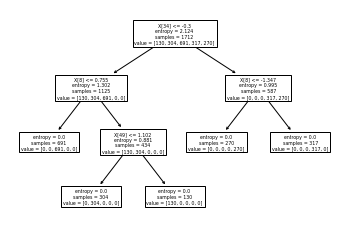

In [5]:
# Train data is called: train_data
# Train labels is called: train_labels
# Test data is called: test_data
# Test labels is called: test_labels

# https://quantdare.com/decision-trees-gini-vs-entropy/
# --> Entropy has slightly better results but slower than Gini
# However, we gave the model no limitations, so Entropy may take a while

time_start_dt = time.time()

# More complex parameters we can add: max_depth=3, min_samples_split=20, min_samples_leaf=20
model_decision_tree = DecisionTreeClassifier(random_state=42, criterion='entropy', min_samples_split=20, min_samples_leaf=20)
model_decision_tree.fit(train_data, train_labels)
prediction_dt = model_decision_tree.predict(test_data)

time_spent_dt = time.time() - time_start_dt
print(":: %s seconds ::" % (time_spent_dt))

recall_dt = recall_score(y_pred=prediction_dt, y_true=test_labels, average='macro')
precision_dt = precision_score(y_pred=prediction_dt, y_true=test_labels, average='macro')
accuracy_dt = accuracy_score(y_pred=prediction_dt, y_true=test_labels)

plot_tree(model_decision_tree)


### Gradient Boosting Model

In [17]:
time_start_gb = time.time()
model_gradient_boosting = GradientBoostingClassifier(n_estimators=50, learning_rate = 0.2, max_depth=20, max_features=2)
model_gradient_boosting.fit(train_data, train_labels, )
prediction_gb = model_gradient_boosting.predict(test_data)
time_spent_gb= time.time() - time_start_gb
print(":: %s seconds ::" % (time_spent_gb))

recall_gb = recall_score(y_pred=prediction_gb, y_true=test_labels, average='macro')
precision_gb = precision_score(y_pred=prediction_gb, y_true=test_labels, average='macro')
accuracy_gb = accuracy_score(y_pred=prediction_gb, y_true=test_labels)

:: 0.27900004386901855 seconds ::


### Random Forest Model

In [18]:
time_start_rf = time.time()

model_random_forest = RandomForestClassifier(random_state=42, n_estimators=100, n_jobs=-1)
model_random_forest.fit(train_data, train_labels, )
prediction_rf = model_random_forest.predict(test_data)

time_spent_rf = time.time() - time_start_rf
print(":: %s seconds ::" % (time_spent_rf))

recall_rf = recall_score(y_pred=prediction_rf, y_true=test_labels, average='macro')
precision_rf = precision_score(y_pred=prediction_rf, y_true=test_labels, average='macro')
accuracy_rf = accuracy_score(y_pred=prediction_rf, y_true=test_labels)

:: 0.19235825538635254 seconds ::


### Comparisons

Confusion Matrix order: Decision Tree, Gradient Boosting, Random Forest


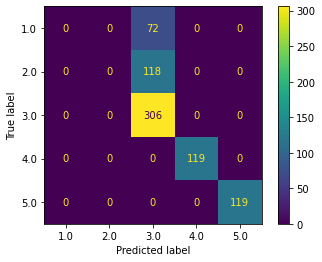

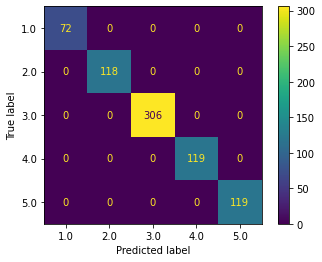

In [19]:
# Show confusion matrix of the 3 models
print('Confusion Matrix order: Decision Tree, Gradient Boosting, Random Forest')
ConfusionMatrixDisplay.from_predictions(y_true=test_labels, y_pred=prediction_dt)
# ConfusionMatrixDisplay.from_predictions(y_true=test_labels, y_pred=prediction_gb)
ConfusionMatrixDisplay.from_predictions(y_true=test_labels, y_pred=prediction_rf)
plt.show()


In [22]:
comparison_table = {
    'Model': ['Decision Tree', 'Gradient Boosting', 'Random Forest'],
    'Accuracy': [accuracy_dt , accuracy_gb, accuracy_rf], 
    'Recall': [recall_dt, recall_gb, recall_rf], 
    'Precision': [precision_dt, precision_gb, precision_rf],
    'Time': [time_spent_dt, time_spent_gb, time_spent_rf]
}
display(pd.DataFrame(comparison_table))


,Model,Accuracy,Recall,Precision,Time
0,Decision Tree,0.741144,0.6,0.523387,0.013999
1,Gradient Boosting,1.000000,1.0,1.000000,0.279000
2,Random Forest,1.000000,1.0,1.000000,0.192358
